# ***Classification des messages spam et non-spam***

# Introduction

La classification des messages spam est un processus qui consiste à identifier et à filtrer les messages électroniques non sollicités, communément appelés "spams", parmi les courriels légitimes. Les spams peuvent inclure des publicités non désirées, des tentatives de phishing ou des contenus malveillants.
Pour résoudre ce problème, on a recours à des techniques d'apprentissage automatique, notamment des modèles de traitement du langage naturel (NLP) comme **BERT (Bidirectional Encoder Representations from Transformers)**. BERT permet de capturer le contexte bidirectionnel des mots dans un message, ce qui est essentiel pour différencier un spam d'un message légitime.

---


Pour améliorer encore ses performances, BERT a été affiné (fine-tuning) sur
des jeux de données spécifiques contenant des e-mails classifiés comme spam ou non-spam. Ce processus de fine-tuning consiste à ajuster les poids du modèle BERT pré-entraîné en fonction des particularités de notre corpus de données, ce qui permet de mieux reconnaître les motifs propres aux spams. En se basant sur ces caractéristiques linguistiques et contextuelles fines, cette approche permet de développer un système efficace de détection automatique des spams, tout en réduisant les erreurs de classification et en optimisant la performance des filtres anti-spam.

# Importation des bibliothèques



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import re
import os
from huggingface_hub import login

# Configuration du token pour s'authentifier

In [ ]:
# Connexion à Hugging Face
login(token=os.getenv('HF_TOKEN'))  # Utilise le secret HF_TOKEN

# Configuration de l'environnement
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Importation du modèle Bert

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Chargement de la base de données

In [ ]:
data = pd.read_csv("/content/25152746-spam.tsv", sep='\t')
data.to_csv('votre_fichier.csv', index=False)
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


# Exploration de la base de données

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
 2   length   5572 non-null   int64 
 3   punct    5572 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.2+ KB


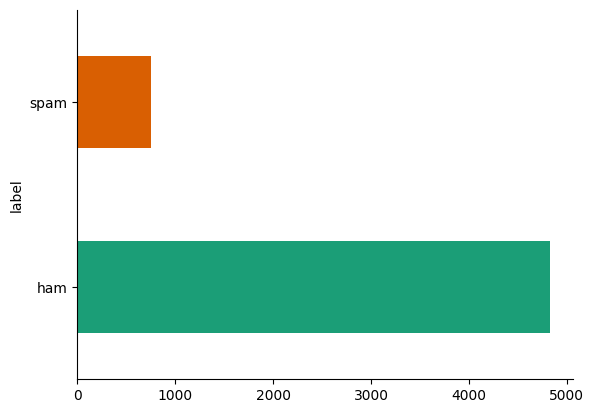

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Group by 'label' and count the occurrences
target_counts = data.groupby('label').size().reset_index(name='Count')
print(target_counts)

  label  Count
0   ham   4825
1  spam    747


In [ ]:
data['label'].value_counts(normalize = True)


,proportion
label,
ham,0.865937
spam,0.134063


# Nettoyage de la base de données

La fonction clean_text nettoie chaque message en supprimant les caractères non alphabétiques, en convertissant tout en minuscules, et en créant une chaîne de texte propre. Elle est ensuite appliquée à chaque message de la colonne "message", et les résultats sont stockés dans une nouvelle colonne "Text" du DataFrame.

In [ ]:
def clean_text(text):
    clean = re.sub('[^a-zA-Z]', ' ', text) # Replacing all non-alphabetic characters with a space
    clean = clean.lower() # converting to lowecase
    clean = clean.split() # splits the cleaned text sms into a list of words
    clean = ' '.join(clean) # joins the list of words back into a string, using a single space as the separator between the words
    return clean

data.loc[:, "Text"] = data["message"].apply(clean_text)

In [ ]:
# Map labels to numerical values: spam -> 1, ham -> 0
label_mapping = {"spam": 1, "ham": 0}
data['label'] = data['label'].map(label_mapping)


In [ ]:
data

,label,message,length,punct,Text
0,0,"Go until jurong point, crazy.. Available only ...",111,9,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry in a wkly comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,49,6,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2,nah i don t think he goes to usf he lives arou...
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,160,8,this is the nd time we have tried contact u u ...
5568,0,Will ü b going to esplanade fr home?,36,1,will b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,7,pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,125,1,the guy did some bitching but i acted like i d...


# Split de la base

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.4,
                                                                    stratify=data['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

<Axes: >

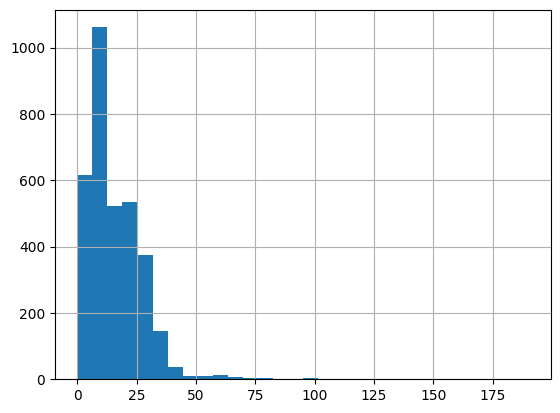

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len=25

# Tokenization & encodage

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),  #batch_encode_plus attend une liste de chaînes de caractères comme entrée.
    max_length = max_seq_len,
    pad_to_max_length=True, #Ce paramètre indique que les séquences doivent être remplies jusqu'à max_length.
    truncation=True, #Cela signifie que si une séquence dépasse max_length, elle sera tronquée pour ne garder que les premiers tokens
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Les **tokens_train**, **tokens_val** et **tokens_test** contiennent les séquences tokenisées et encodées des ensembles d'entraînement, de validation et de test, comprenant chacun :

*   les identifiants des tokens (**input_ids**) : sont des identifiants numériques qui représentent chaque token (ou mot) de la séquence d'entrée.
*    les masques d'attention (**attention_mask**) : est untableau ou chaque position a une valeur de 1 si le token est réel (non-padding) et 0 s'il s'agit d'un token de padding.



# From tokens to tensors

On va convertir les données récupérées (**input IDs, attention mask, labels**) en **tenseurs PyTorch**, qui sont le format de données requis pour l'entraînement avec PyTorch.


### **NB**: Les valeurs dans ces tenseurs sont des entiers, représentant les indices des tokens dans le vocabulaire du modèle.

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


# Dataloader

Les **DataLoader** facilitent l'entraînement des modèles en gérant le chargement, le traitement et l'organisation des données en batches, tout en optimisant l'utilisation de la mémoire et en permettant une plus grande flexibilité dans la manière dont les données sont traitées

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### --> Ce code prépare les ensembles de données pour l'entraînement et la validation en les organisant sous forme de TensorDataset, puis en les chargeant par batches à l'aide de DataLoader, avec des échantillonneurs appropriés pour chaque ensemble. Cela facilite le processus d'entraînement et d'évaluation du modèle.
NB:
*   **TensorDataset** : Une classe qui permet de combiner plusieurs tenseurs en un seul dataset, où chaque tenseur correspond à un ensemble de données.

*   **DataLoader** : Un utilitaire qui permet de charger les données de manière efficace par batches.
*   **RandomSampler** : Échantillonneur qui permet de sélectionner des échantillons de manière aléatoire.


*   **SequentialSampler** : Échantillonneur qui fournit les échantillons dans l'ordre dans lequel ils apparaissent.









# architecture personnalisée du BERT

Cette classe BERT_Arch utilise un modèle BERT pré-entraîné pour la classification de texte. Elle inclut deux couches fully connected (FC) pour réduire la sortie de BERT (768 dimensions) à 512, puis à 2 dimensions, correspondant aux classes de classification. Le modèle utilise la fonction d'activation ReLU après la première couche FC et applique un dropout pour éviter le surapprentissage. Enfin, la sortie passe par une fonction LogSoftmax pour produire des probabilités log-scaled sur les deux classes. La passe avant prend en entrée les tokens et les masques d'attention, utilise la sortie [CLS] de BERT, puis applique ces transformations.

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        # Utiliser le modèle BERT pré-entraîné
        self.bert = bert

        # Définir une couche de dropout pour régularisation
        self.dropout = nn.Dropout(0.1)

        # Fonction d'activation ReLU qui introduit la non-linéarité dans le modèle.
        self.relu = nn.ReLU()

        # Première couche fully connected
        self.fc1 = nn.Linear(768, 512)

        # Deuxième couche fully connected (couche de sortie)
        self.fc2 = nn.Linear(512, 2)

        # Fonction d'activation LogSoftmax
        self.softmax = nn.LogSoftmax(dim=1)

    # Définir la passe avant
    def forward(self, sent_id, mask):

        # Passer les données à travers BERT, CLS token
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) #Les données tokenisées (input_ids) et le masque d'attention sont passés à travers BERT.

        # Appliquer la première couche fully connected
        x = self.fc1(cls_hs)

        # Appliquer ReLU
        x = self.relu(x)

        # Appliquer dropout
        x = self.dropout(x)

        # Appliquer la deuxième couche fully connected (couche de sortie)
        x = self.fc2(x)

        # Appliquer la fonction LogSoftmax
        x = self.softmax(x)

        return x


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Instancier le modèle BERT_Arch avec BERT
model = BERT_Arch(bert)

# Utiliser GPU si disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)


# Définir l'optimiseur AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)



# Geler les poids de BERT

Ici, les paramètres de BERT ne vont pas être mis à jour pendant l'entraînement. Cela signifie que les poids du modèle BERT seront conservés tels quels, sans ajustement via la rétropropagation.

In [ ]:
# Geler les poids de BERT
for param in model.bert.parameters():
    param.requires_grad = False

# class weights

Cette partie calcule et applique des poids de classe pour traiter le problème de déséquilibre des classes dans note jeu de données . Cela permet d'améliorer les performances du modèle sur les classes minoritaires ("spam") en leur donnant plus d'importance lors de l'entraînement. Les poids sont intégrés dans la fonction de perte pour s'assurer que le modèle apprend à prédire correctement les étiquettes sous-représentées.

In [ ]:
# Importation nécessaire
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe:(balnced: la fonction va ajuster les poids de chaque classe pour compenser le déséquilibre dans le nombre d'exemples que chaque classe possède)
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Afficher les poids de classe
print("Poids de classe :", class_wts)



# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)


Poids de classe : [0.57737478 3.73102679]


# Fonction d'entrainement et d'evaluation

In [ ]:

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Fonction d'entraînement avec early stopping
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, patience=5):
    best_val_loss = float('inf')

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            # Charger les batchs sur le GPU (ou CPU)
            sent_id, mask, labels = [t.to(device) for t in batch]

            # Vider les gradients de l'optimiseur
            model.zero_grad()

            # Faire passer les données dans le modèle
            preds = model(sent_id, mask)

            # Calculer la perte
            loss = cross_entropy(preds, labels)

            # Backpropagation
            loss.backward()

            # Mettre à jour les poids
            optimizer.step()
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #limiter la norme des gradients pour gérer le problème des gradients explosifs

            # model predictions are stored on GPU. So, push it to CPU
            preds=preds.detach().cpu().numpy()


            total_loss += loss.item()

        # Calcul de la perte moyenne pour l'entraînement
        avg_train_loss = total_loss / len(train_dataloader)
        print(f'Époque {epoch + 1} | Perte moyenne sur l entraînement : {avg_train_loss}')

        # Évaluation sur l'ensemble de validation
        model.eval()
        val_loss, correct_preds = 0, 0

        with torch.no_grad():
            for batch in val_dataloader:
                sent_id, mask, labels = [t.to(device) for t in batch]
                preds = model(sent_id, mask)

                # Calcul de la perte
                loss = cross_entropy(preds, labels)
                val_loss += loss.item()

                # Calcul des prédictions correctes
                _, predicted_labels = torch.max(preds, dim=1)
                correct_preds += (predicted_labels == labels).sum().item()
                # Sauvegarder le modèle si la perte de validation est la meilleure
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), 'best_spam_classifier_model.pt')
                    print(f"Best model saved at epoch {epoch + 1} with validation loss {val_loss:.3f}")

        # Calcul de la perte et précision moyennes pour la validation
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = correct_preds / len(val_dataloader.dataset)

        print(f'Époque {epoch + 1} | Perte moyenne sur validation : {avg_val_loss} | Précision : {val_accuracy * 100:.2f}%')



        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping activé à l'époque {epoch + 1}")
            break

# Entrainement du modèle

In [ ]:
# Appeler la fonction pour entraîner le modèle
train_model(model, train_dataloader, val_dataloader, cross_entropy, optimizer, epochs=100)

Époque 1 | Perte moyenne sur l entraînement : 0.6501576713153294
Best model saved at epoch 1 with validation loss 0.641
Époque 1 | Perte moyenne sur validation : 0.6315876398767744 | Précision : 62.21%
Époque 2 | Perte moyenne sur l entraînement : 0.6339636655080886
Époque 2 | Perte moyenne sur validation : 0.6230863758495876 | Précision : 55.66%
Époque 3 | Perte moyenne sur l entraînement : 0.6237607972962516
Époque 3 | Perte moyenne sur validation : 0.6123512574604579 | Précision : 56.55%
Époque 4 | Perte moyenne sur l entraînement : 0.6162673232101259
Best model saved at epoch 4 with validation loss 0.597
Époque 4 | Perte moyenne sur validation : 0.592292400768825 | Précision : 72.89%
Époque 5 | Perte moyenne sur l entraînement : 0.6001615847860063
Best model saved at epoch 5 with validation loss 0.574
Époque 5 | Perte moyenne sur validation : 0.5789775141647884 | Précision : 78.64%
Époque 6 | Perte moyenne sur l entraînement : 0.5869350944246564
Époque 6 | Perte moyenne sur validat

# Model saving

In [ ]:
#load weights of best model
path = 'best_spam_classifier_model.pt'
model.load_state_dict(torch.load(path))

<ipython-input-35-481a329389e3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
# Créer le dataset pour l'ensemble de test
test_data = TensorDataset(test_seq, test_mask, test_y)

# Créer un sampler pour l'ensemble de test
test_sampler = SequentialSampler(test_data)

# Créer le DataLoader pour l'ensemble de test
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Fonction d'évaluation
def evaluate_model(model, test_dataloader):
    model.eval()  # Passer en mode évaluation
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_dataloader:
            sent_id, mask, labels = [t.to(device) for t in batch]

            # Faire une prédiction avec le modèle
            preds = model(sent_id, mask)

            # Calculer la perte pour l'ensemble de test
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            # Calculer l'accuracy
            _, predicted_labels = torch.max(preds, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
    avg_test_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / len(test_dataloader.dataset)
    print(f'Perte moyenne sur l\'ensemble de test: {avg_test_loss}')
    print(f'Précision (accuracy) sur l\'ensemble de test: {accuracy * 100:.2f}%')

# Appeler la fonction d'évaluation
evaluate_model(model, test_dataloader)


Perte moyenne sur l'ensemble de test: 0.2071976831981114
Précision (accuracy) sur l'ensemble de test: 94.44%


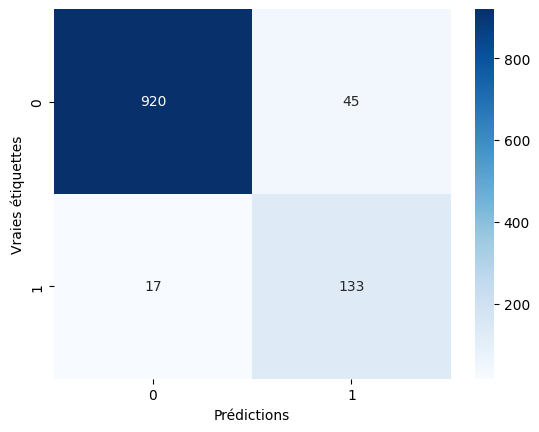

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds_list, true_labels_list = [], []
model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        sent_id, mask, labels = [t.to(device) for t in batch]
        preds = model(sent_id, mask)
        _, predicted_labels = torch.max(preds, dim=1)

        preds_list.extend(predicted_labels.cpu().numpy())
        true_labels_list.extend(labels.cpu().numpy())

cm = confusion_matrix(true_labels_list, preds_list)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_list, preds_list))


              precision    recall  f1-score   support

           0       0.98      0.95      0.97       965
           1       0.75      0.89      0.81       150

    accuracy                           0.94      1115
   macro avg       0.86      0.92      0.89      1115
weighted avg       0.95      0.94      0.95      1115



In [ ]:
def test_model(model, tokenizer, messages, max_seq_len):
    # Tokenisation des messages d'entrée
    tokens_test = tokenizer.batch_encode_plus(
        messages,
        max_length=max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    # Conversion en tenseurs
    test_seq = torch.tensor(tokens_test['input_ids']).to(device)
    test_mask = torch.tensor(tokens_test['attention_mask']).to(device)

    # Évaluation du modèle
    model.eval()
    with torch.no_grad():
        preds = model(test_seq, test_mask)
        _, predicted_labels = torch.max(preds, dim=1)

    # Afficher les résultats
    for i, message in enumerate(messages):
        label = "Spam" if predicted_labels[i].item() == 1 else "ham"
        print(f"Message: {message}")
        print(f"Prédiction: {label}\n")


In [ ]:
# Exemple de nouveaux messages à tester
new_messages = [

    "Reminder: our meeting is scheduled for tomorrow at 10 a.m.",
    "You are the 1000th visitor! Click to win a prize!",
    "Hello, here are the documents you requested.",
    "Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!",
    "I'm leaving my house now",
    "You’ve won a free iPhone! Claim your prize now!",
    "Your account has been compromised. Click here to secure it immediately.",
    "Happy birthday! Hope you have an amazing day!"
]

# Tester les nouveaux messages
test_model(model, tokenizer, new_messages, max_seq_len)


Message: Reminder: our meeting is scheduled for tomorrow at 10 a.m.
Prédiction: ham

Message: You are the 1000th visitor! Click to win a prize!
Prédiction: Spam

Message: Hello, here are the documents you requested.
Prédiction: ham

Message: Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!
Prédiction: Spam

Message: I'm leaving my house now
Prédiction: ham

Message: You’ve won a free iPhone! Claim your prize now!
Prédiction: Spam

Message: Your account has been compromised. Click here to secure it immediately.
Prédiction: Spam

Message: Happy birthday! Hope you have an amazing day!
Prédiction: ham



# Synthèse

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [ ]:
import gradio as gr
import torch
from transformers import BertTokenizer

# Assurez-vous d'avoir votre modèle BERT défini quelque part
# model = BERT_Arch(bert)  # Déjà fait dans votre code

# Utiliser GPU si disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Chargez le tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def test_model(message, max_seq_len=128):
    # Tokenisation du message d'entrée
    tokens_test = tokenizer.batch_encode_plus(
        [message],  # Message unique à classer
        max_length=max_seq_len,
        padding=True,
        truncation=True,
        return_tensors='pt'  # Retourner des tenseurs PyTorch
    )

    # Conversion en tenseurs et transfert sur le device
    test_seq = tokens_test['input_ids'].to(device)
    test_mask = tokens_test['attention_mask'].to(device)

    # Évaluation du modèle
    model.eval()
    with torch.no_grad():
        preds = model(test_seq, test_mask)
        _, predicted_label = torch.max(preds, dim=1)

    # Convertir la prédiction en étiquette lisible
    label = "Spam" if predicted_label.item() == 1 else "Ham"

    # Retourner l'étiquette correspondante (Spam ou Ham)
    return label

# Créer l'interface Gradio
iface = gr.Interface(
    fn=test_model,
    inputs="text",  # Gradio attend des entrées de type texte
    outputs="text",  # La sortie sera "Spam" ou "Ham"
    title=" Spam/Ham classification using BERT",
    description="Enter a message to classify it as spam or not spam"
)

iface.launch()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3a7d97ad4d43c94210.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
